In [1]:
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
train_data = pd.read_csv(r"/content/train.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)
val_data = pd.read_csv(r"/content/validation.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)
test_data = pd.read_csv(r"/content/test.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)

In [3]:
train_data.head()

,id,text,labels
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,non-hostile
2,3,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील...",non-hostile
3,4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive"
4,5,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स...,non-hostile


In [4]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\w+", "", text)  # Remove URLs and mentions
    text = re.sub(r"[^\u0900-\u097F\s]+", "", text)  # Remove non-Devanagari chars
    return text.strip()

# Clean the text in all datasets
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
val_data['cleaned_text'] = val_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

In [5]:
# Map multi-labels to single labels
label_mapping = {
    "defamation": "defamation",
    "hate": "hate",
    "offensive": "offensive",
    "fake": "fake",
    "non-hostile": "non-hostile"
}
train_data['single_label'] = train_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))
val_data['single_label'] = val_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))
test_data['single_label'] = test_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))

In [6]:
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['single_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['single_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['single_label'])

In [7]:
# Load tokenizer and set max length
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 128

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
# Define a custom model with Sequential layers
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, num_labels):
        super(CustomDistilBERT, self).__init__()

        # Load DistilBERT
        self.distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

        # Additional layers using Sequential
        self.classifier = tf.keras.Sequential([
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.4),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dense(32, activation='relu'),
            Dense(num_labels, activation='softmax')  # Adjust activation for multi-class classification
        ])

    def call(self, inputs):
        # DistilBERT outputs
        input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)

        # Get CLS token output (batch_size, hidden_size)
        cls_output = distilbert_output.last_hidden_state[:, 0, :]

        # Pass through the Sequential layers
        output = self.classifier(cls_output)

        return output

# Define the number of labels and initialize the model
num_labels = len(label_encoder.classes_)
model = CustomDistilBERT(num_labels)
optimizer = Adam(learning_rate=1e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [9]:
# Compile model with sparse categorical crossentropy for integer labels
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Preprocess data function for TensorFlow format
def preprocess_data(texts, labels, tokenizer, max_length):
    encodings = tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return encodings, tf.convert_to_tensor(labels)

# Create TensorFlow datasets
train_encodings, train_labels = preprocess_data(train_data['cleaned_text'].tolist(), train_data['encoded_labels'].tolist(), tokenizer, max_length)
val_encodings, val_labels = preprocess_data(val_data['cleaned_text'].tolist(), val_data['encoded_labels'].tolist(), tokenizer, max_length)

# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(32)

In [11]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 68s 119ms/step - accuracy: 0.5195 - loss: 1.4212 - val_accuracy: 0.5364 - val_loss: 1.2823
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 56s 69ms/step - accuracy: 0.5377 - loss: 1.2734 - val_accuracy: 0.5364 - val_loss: 1.2573
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.5377 - loss: 1.2515 - val_accuracy: 0.5364 - val_loss: 1.2411
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.5379 - loss: 1.2354 - val_accuracy: 0.5413 - val_loss: 1.2294
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.5392 - loss: 1.2236 - val_accuracy: 0.5413 - val_loss: 1.2201
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.5420 - loss: 1.2143 - val_accuracy: 0.5450 - val_loss: 1.2125
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.5425 - loss: 1.2065 - val_accuracy: 0.5388 - val_loss: 1.2060
Epoch 8/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.5414 - loss: 1.1996 -

In [12]:
# Preprocess test data
test_encodings, test_labels = preprocess_data(test_data['cleaned_text'].tolist(), test_data['encoded_labels'].tolist(), tokenizer, max_length)

# Create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(32)

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the testing accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.5838 - loss: 1.1140
Test Accuracy: 0.5777


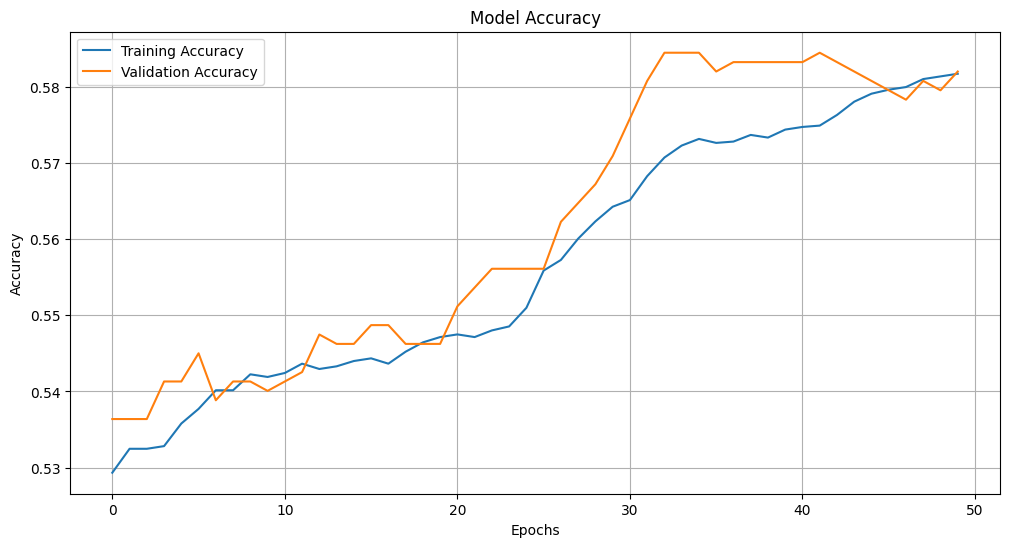

In [14]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

# Call the function to plot accuracy
plot_accuracy(history)

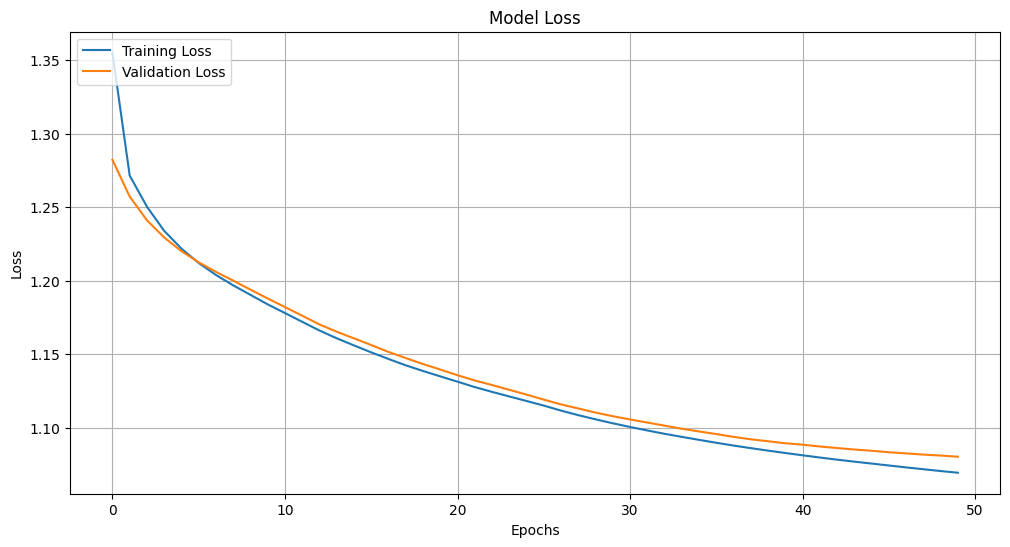

In [15]:
def plot_loss(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

# Call the function to plot loss
plot_loss(history)

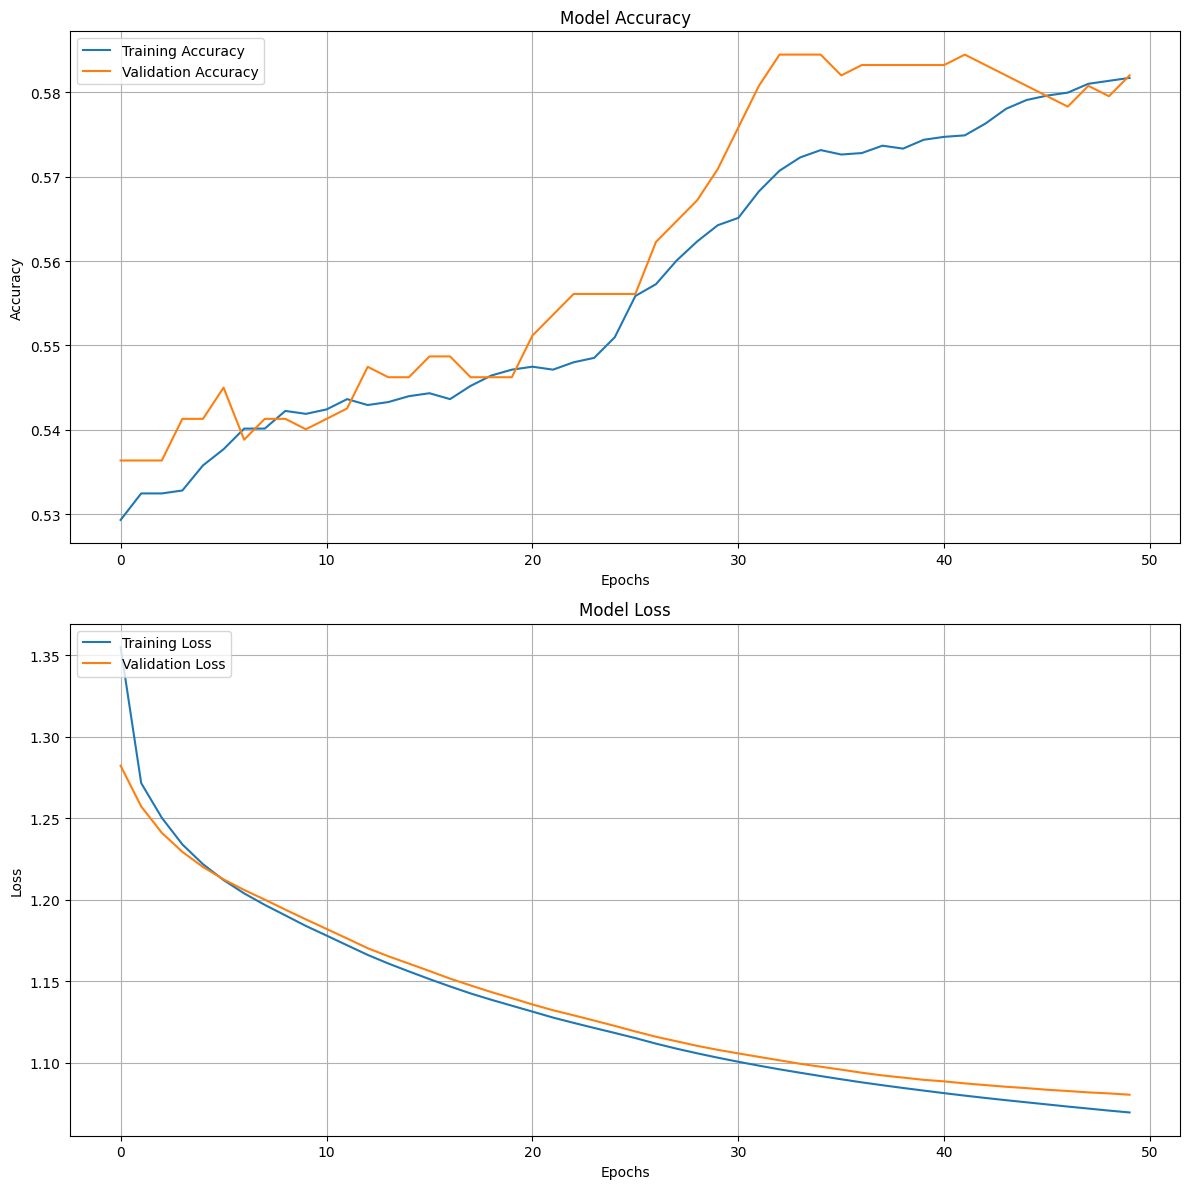

In [16]:
def plot_accuracy_and_loss(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper left')
    ax2.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot both accuracy and loss
plot_accuracy_and_loss(history)

In [ ]:
# # Example prediction function
# def predict_hostility(text):
#     embedding = get_bert_embeddings(text)
#     prediction = model.predict(embedding)
#     predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
#     return predicted_label

In [ ]:
# # Example usage
# example_text = "कंगना रनौत के अवैध ऑफिस के लिए हाइकोर्ट्स के पास टाइम ही टाइम है लेकिन संजीव भट्ट , डॉ कफील , उमर खालिद पर होने वाली तानाशाही…"
# print(f"Predicted Label: {predict_hostility(example_text)}")
